# Disclosure:
*This post is for informational and educational purposes only. It does not constitute financial advice. For personalized guidance, please consult a qualified financial professional.*

---

**Author:**  
**Alexander Richt, CFA**

As a dedicated professional in finance and economics, I thrive in roles that integrate technical expertise with strategic decision-making. My passion lies in leveraging cutting-edge programming, advanced modeling, and analytics to deliver impactful results in the corporate, investment, and finance sectors.

**Credentials:**  
- CFA Charterholder  
- MSc in Economics (Econometrics specialization)  
- Multiple technical certifications in analytics, AI, data science and data engineering  

# Estimating Return: CAPM

The Capital Asset Pricing Model (CAPM) is one of the most traditional and widely used asset pricing models in finance. It was originally developed by William F. Sharpe, John Lintner, and Jan Mossin in the 1960s and built upon the foundational ideas of Harry Markowitz's Modern Portfolio Theory, which introduced the concept of portfolio diversification and risk-return optimization by combining various assets with differing risk-return characteristics together.

At its core, the CAPM measures the relationship between an asset's systematic risk, represented by its Beta ($\beta_t$), and its expected return. Beta measures the sensitivity of an asset’s returns to the returns of the overall market, serving as a proxy for the asset's exposure to market-wide risks. A Beta of 1 indicates that the asset’s price moved in tandem with the market, a Beta greater than 1 suggests higher sensitivity (and risk) relative to the market, while a Beta less than 1 implies lower sensitivity and risk.

CAPM uses the following formula to estimate the expected return of an asset:
$$ 
e_a = r_f + \beta * (e_m - r_f) 
$$

Where:
- $e_a$: is the expected return of the given asset.
- $r_f$: is the risk free rate. In this case, we use the rolling average 10-year treasury bond over a 12 month rolling window
- $\beta_t$ (Beta): is known as the Beta of the asset. Which is the slope of the equation and represents how much the asset changes for a change in the given underlying market. A Beta greater than 1 means the asset is expected to change on avergae at a rate larger than the market for any given gain or loss
- $e_m$: is the expected return of the market. Estimated by taking the average annualized return over time

CAPM itself, has the advantage of its simplicity and relative inteprotatability. However, this comes at a cost. It's simplicity will not result in the most optimal beta estimation or model fit and additionally, the model makes assumptions that investors are rational, markets are efficient, and that the only risk requiring compensation is systematic risk—non-diversifiable risk that cannot be mitigated through diversification. Nonetheless, it is a historically foundationally model within the investment industry as it provides a structured framework for estimating the cost of equity and evaluating whether an asset offers adequate compensation for its inherent risk.

Below - we follow a practical application of the CAPM model using the following:

1. Daily Closing Prices of the S&P 500 since 1981 to estimate expected market return ($e_m$)
2. Daily Closing Prices of Apple Stock since 1981 to estimate Beta against the market ($e_a$, $\beta$)
3. Nominal monthly 10-Year Treasury Bills since 1981 inteporlated to daily figures to estimate the risk free rate ($r_f$)

In [49]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import datetime
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt

start_date = "1980-01-01"
end_date = "2024-12-22"

gs10 = pdr.get_data_fred('GS10', start=start_date, end=end_date)

business_days = pd.date_range(start=start_date, end=end_date, freq='B')

gs10_daily = gs10.reindex(business_days).interpolate()

rolling_avg = gs10_daily['GS10'].rolling(window=252).mean()

risk_free_rate_data = pd.DataFrame({'Rolling_Risk_Free_Rate': rolling_avg})

risk_free_rate_data.tail()

risk_free_rate = risk_free_rate_data['Rolling_Risk_Free_Rate'].iloc[-1]
print(f"The current annualized average risk-free rate based on nominal yields is {risk_free_rate:.5f}%")

The current annualized average risk-free rate based on nominal yields is 4.24183%


## Estimating Risk Free Rate

The monthly GS10 (10-year Treasury Bill) rates are converted into daily figures. These daily rates are averaged over a rolling yearly window to calculate the rolling risk-free rate. This rolling rate is used to estimate historical excess returns for the market and assets, as well as the expected returns of the asset over time.

$$ 
e_{a_t} = r_{f_t} + \beta_t * (e_{m_t} - r_{f_t}) 
$$

$$
Market Excess Return = e_{m_t} - r_{f_t}
$$

$$
Asset Excess Return = e_{a_t} - r_{f_t}
$$

Where:

- $r_{f_t}$ =
$$
r_{f_t} = \frac{1}{N} \sum_{i=t-N+1}^{t} r_{f_i}
$$

$$
\text{Where:}
$$

$$
\begin{aligned}
& r_{f_t}: \text{Risk-free rate at time } t, \text{ calculated as the average over a rolling yearly window.} \\
& r_{f_i}: \text{Daily 10-year Treasury Bill rate on day } i. \\
& N: \text{Number of trading days in a year (commonly 252 for daily trading data).} \\
& t: \text{Current time index.}
\end{aligned}
$$


In [20]:
from yahoo_fin.stock_info import get_data

ticker = "^GSPC"  # S&P 500 index
start_date = "1980-01-01"
end_date = "2024-12-21"

sp500 = get_data(ticker, start_date=start_date, end_date=end_date, index_as_date=True, interval="1d")

sp500.tail()

,open,high,low,close,adjclose,volume,ticker
2024-12-16,6063.790039,6085.189941,6059.140137,6074.080078,6074.080078,4391100000,^GSPC
2024-12-17,6052.549805,6057.680176,6035.189941,6050.609863,6050.609863,4544500000,^GSPC
2024-12-18,6047.649902,6070.669922,5867.790039,5872.160156,5872.160156,5246960000,^GSPC
2024-12-19,5912.709961,5935.520020,5866.069824,5867.080078,5867.080078,4896880000,^GSPC
2024-12-20,5842.000000,5982.060059,5832.299805,5930.850098,5930.850098,8223220000,^GSPC


In [21]:
from dotenv import load_dotenv
import mysql.connector

load_dotenv(dotenv_path="C:\\Users\\alexa\\PycharmProjects\\Financial Research\\fin-scope\\pythonProject\\.env", override=True)

password = os.getenv("password")
database = os.getenv("database")

db_config = {
    "host": "localhost",
    "user": "root",
    "password": password,
    "database": database,
    "auth_plugin": "mysql_native_password"
}

In [22]:
try:
    print("Connecting to the database...")
    db_connection = mysql.connector.connect(**db_config)
    cursor = db_connection.cursor()
except mysql.connector.Error as e:
    print("Error while connecting to MySQL", e)

Connecting to the database...


In [23]:
Data_Query = f"SELECT * FROM stock_prices WHERE ticker = 'AAPL' AND date >= '1980-01-01' AND date <= '2024-12-21'"

cursor.execute(Data_Query)

Indicator_Data = cursor.fetchall()

columns = [column[0] for column in cursor.description]

apple_stock_prices = pd.DataFrame(Indicator_Data, columns=columns)
apple_stock_prices.tail()

,id,date,open,high,low,close,adjclose,volume,ticker,exchange,hash_key
11094,174397,2024-12-16,247.99,251.38,247.65,251.04,251.04,51694800,AAPL,NASDAQ,6c8bc9b7f777d1e6a4344a83ce6c29b3
11095,174398,2024-12-17,250.08,253.83,249.78,253.48,253.48,51356400,AAPL,NASDAQ,e4d3ee4c368b183a4b36c21f2503a8a5
11096,174399,2024-12-18,252.16,254.28,247.74,248.05,248.05,56774100,AAPL,NASDAQ,6f387835cad61c835f62e17a2eaec862
11097,174400,2024-12-19,247.50,252.00,247.09,249.79,249.79,60882300,AAPL,NASDAQ,c6af4020ff25fc554f03801693efcb12
11098,174401,2024-12-20,248.04,255.00,245.69,254.49,254.49,146890100,AAPL,NASDAQ,71d95dddd76a3fcba0cbdb69a26c0812


## Aligning indexes and frequency

When working with multiple time series datasets, especially in financial analysis it is important to ensure that:

1. Index - The foundation of any time series analysis is a well-defined index, typically representing time. Each time series object must have its index aligned with a common date column
2. Frequency - Frequency refers to the time interval between data points (e.g., daily, weekly, monthly). For meaningful comparisons and calculations, the time series objects must have the same frequency. (In this case it is in Business Days = 252)
    - If datasets have different frequencies, resampling is necessary. This involves either upsampling (increasing frequency, e.g., from weekly to daily) or downsampling (decreasing frequency, e.g., from daily to weekly)
    - Upsampling was applied to the 10-Year Treasury Bills
3. Normalization - The Index is normalized in order to ensure the given time series objects are compariable. Normalization typically involves setting a base value (often the first value) to 1 or 100 and expressing subsequent values as a proportion or percentage of this base.
$$
N_t = \frac{X_t}{X_{base}} \times 100
$$
4. Handling Missing Valuess - Backfilling (also known as "forward fill" in some contexts) is a method to address these missing values. It propagates the last observed non-missing value forward in time to fill subsequent missing values
   - Other methods, such as forward fill (using the next available value) or interpolation (estimating values based on surrounding data points), might be more appropriate in other situations

$$
Z_t =
\begin{cases}
    Y_t, & \text{if } Y_t \text{ is not NA} \\
    Z_{t-1}, & \text{if } Y_t \text{ is NA}
\end{cases}
$$


In [24]:
risk_free_rate_data = risk_free_rate_data.reset_index()
risk_free_rate_data['index'] = pd.to_datetime(risk_free_rate_data['index'])
risk_free_rate_data = risk_free_rate_data.set_index('index')
risk_free_rate_data = risk_free_rate_data.asfreq('B')  
risk_free_rate_data.index = risk_free_rate_data.index.normalize()
risk_free_rate_data[['Rolling_Risk_Free_Rate']] = risk_free_rate_data[['Rolling_Risk_Free_Rate']].bfill()
risk_free_rate_data = risk_free_rate_data.loc["1981-01-01":"2024-12-21"]


sp500 = sp500.reset_index()
sp500['index'] = pd.to_datetime(sp500['index'])
sp500 = sp500.set_index('index')
sp500 = sp500.asfreq('B')  
sp500.index = sp500.index.normalize()
sp500[['close']] = sp500[['close']].bfill()
sp500 = sp500.loc["1981-01-01":"2024-12-21"]


apple_stock_prices = apple_stock_prices.reset_index()
apple_stock_prices['date'] = pd.to_datetime(apple_stock_prices['date'])
apple_stock_prices = apple_stock_prices.set_index('date')
apple_stock_prices = apple_stock_prices.asfreq('B')  
apple_stock_prices.index = apple_stock_prices.index.normalize()
apple_stock_prices[['close']] = apple_stock_prices[['close']].bfill()
apple_stock_prices = apple_stock_prices.loc["1981-01-01":"2024-12-21"]


In [36]:
sp500['Daily_Return'] = sp500['close'].pct_change()
sp500[['Daily_Return']] = sp500[['Daily_Return']].bfill()

sp500['Cumulative_Return'] = (1 + sp500['Daily_Return']).cumprod()

annualization_factor = 252
total_periods = len(sp500)
years = total_periods / annualization_factor

cumulative_return = sp500['Cumulative_Return'].iloc[-1] - 1
annualized_return_formula = ((1 + cumulative_return) ** (1 / years)) - 1

print(f"Cumulative Return: {cumulative_return:.2%}")
print(f"Annualized Return: {annualized_return_formula:.2%}")


Cumulative Return: 4250.04%
Annualized Return: 8.64%


In [37]:
apple_stock_prices['Daily_Return'] = apple_stock_prices['close'].pct_change()
apple_stock_prices[['Daily_Return']] = apple_stock_prices[['Daily_Return']].bfill()

apple_stock_prices['Cumulative_Return'] = (1 + apple_stock_prices['Daily_Return']).cumprod()

total_periods = len(apple_stock_prices)
years = total_periods / 252 

cumulative_return = apple_stock_prices['Cumulative_Return'].iloc[-1] - 1
annualized_return_formula = ((1 + cumulative_return) ** (1 / years)) - 1

print(f"Cumulative Return: {cumulative_return:.2%}")
print(f"Annualized Return (Using Formula): {annualized_return_formula:.2%}")

Cumulative Return: 165133.93%
Annualized Return (Using Formula): 17.68%


## Cumulative and Annualized Return

The cumulative and annualized return over time gives us a good baseline in terms of the performance of the S&P500 and Apple. Since 1981, both the S&P 500 and Apple have demonstrated remarkable performance. The S&P 500 achieved a cumulative return of 4,250% (8.64% annualized), while Apple's cumulative return reached an extraordinary 165,134% (17.68% annualized).

Cumulative return measures the total return of an investment over a specific period, regardless of the fluctuations in between:
$$R_{cum} = \frac{P_n - P_0}{P_0} \quad \text{or} \quad R_{cum} = \frac{P_n}{P_0} - 1$$

Annualized return converts the cumulative return over a given period into an equivalent annual rate:
$$R_{ann} (\%) = \left((1 + R_{cum})^{\frac{1}{n}} - 1\right) \times 100$$

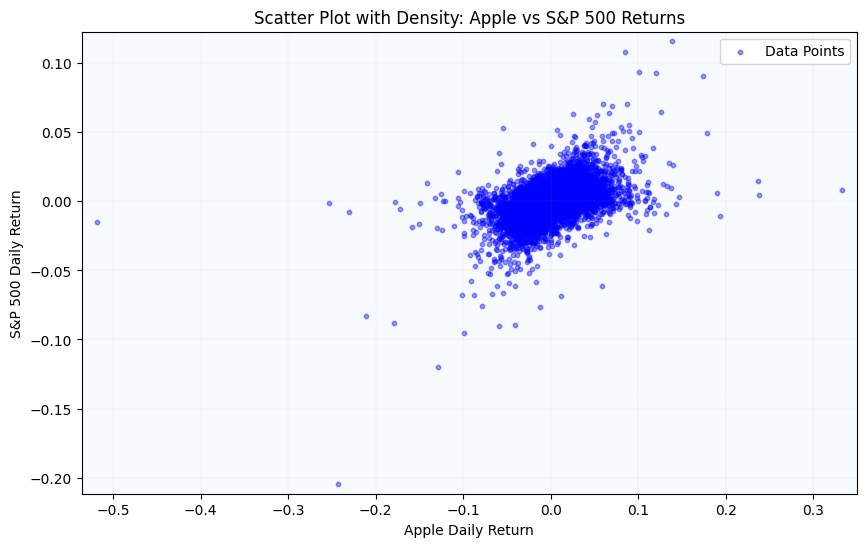

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=apple_stock_prices['Daily_Return'], 
    y=sp500['Daily_Return'], 
    cmap="Blues", 
    fill=True, 
    thresh=0, 
    levels=30
)
plt.scatter(
    apple_stock_prices['Daily_Return'], 
    sp500['Daily_Return'], 
    color="blue", 
    alpha=0.4, 
    s=10, 
    label="Data Points")
plt.xlabel("Apple Daily Return")
plt.ylabel("S&P 500 Daily Return")
plt.title("Scatter Plot with Density: Apple vs S&P 500 Returns")
plt.grid(True, linestyle='--', linewidth=0.1)
plt.legend()
plt.show()

### Scatter Plot of Excess Returns

The scatter plot visualizes the relationship between Apple's daily returns and the S&P 500's daily returns.

The plot hints at an interesting dynamic. Apple seems to outperform the market both during periods of market growth and, to a lesser extent, during market declines. This characteristic could be appealing to investors seeking a stock that tends to participate in market upturns while offering some degree of downside protection.

- General Trend: The data points cluster around the origin, indicating that both Apple and the S&P 500 tend to have similar daily returns.
- Asymmetry: There's a slight rightward skew in the data. This suggests that Apple may exhibit higher returns (relative to the market) on days when the market also experiences positive returns.
- Outliers: A few outliers are visible, particularly in the lower left quadrant. These represent instances where Apple's returns were significantly negative even when the market experienced positive returns or less negative returns.

In [39]:
apple_sp500 = sp500[['Daily_Return']].rename(columns={'Daily_Return': 'Market_Daily_Return'}).join(
    apple_stock_prices[['Daily_Return']].rename(columns={'Daily_Return': 'Stock_Daily_Return'}).join(
        risk_free_rate_data[['Rolling_Risk_Free_Rate']].rename(columns={'Rolling_Risk_Free_Rate': 'Rolling_Risk_Free_Rate'}),
        how='inner'
    ),
    how='inner'
)

apple_sp500['Market_Excess_Return'] = apple_sp500['Market_Daily_Return'] - apple_sp500['Rolling_Risk_Free_Rate'] / 252
apple_sp500['Stock_Excess_Return'] = apple_sp500['Stock_Daily_Return'] - apple_sp500['Rolling_Risk_Free_Rate'] / 252
apple_sp500

,Market_Daily_Return,Stock_Daily_Return,Rolling_Risk_Free_Rate,Market_Excess_Return,Stock_Excess_Return
index,,,,,
1981-01-01,0.000000,0.000000,11.486171,-0.045580,-0.045580
1981-01-02,0.000000,0.000000,11.490208,-0.045596,-0.045596
1981-01-05,0.011955,-0.021738,11.494036,-0.033656,-0.067349
1981-01-06,0.001087,-0.044448,11.497655,-0.044538,-0.090074
1981-01-07,-0.022010,-0.042633,11.501065,-0.067649,-0.088272
...,...,...,...,...,...
2024-12-16,0.003799,0.011728,4.237135,-0.013015,-0.005086
2024-12-17,-0.003864,0.009720,4.238333,-0.020683,-0.007099
2024-12-18,-0.029493,-0.021422,4.239524,-0.046316,-0.038245


## Estimating Beta using Ordinary Least Squares (OLS) Regression

The **Capital Asset Pricing Model (CAPM)** relies on beta ($\beta$) to quantify a stock's systematic risk, or its sensitivity to market movements. One common and straightforward method for estimating beta is Ordinary Least Squares (OLS) regression. The resulting coeffecient of the regression model is the beta. Which reflects the unit change in the return of the stock for a unit change in the return of the market (the slope). 

$$y_i = \alpha + \beta x_i + \varepsilon_i$$

Where:
- Dependent Variable ($y_i$): The excess return of the stock (e.g., Apple). This is calculated as the stock's return minus the risk-free rate of return
- Independent Variable ($x_i$): The excess return of the market (e.g., the S&P 500). This is calculated as the market's return minus the risk-free rate of return
-  $\alpha$ is the intercept
$$
\alpha = \bar{y} - \beta \bar{x}
$$
-  $\beta$ is the slope (beta)
$$
\beta = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n} (x_i - \bar{x})^2}
$$
-  $\varepsilon_i$ is the error term.

**Interpretation of Beta (β):** Beta measures the systematic risk, or the sensitivity of the stock's excess return to changes in the market's excess return.

- β = 1: The stock's excess return is expected to move in line with the market's excess return.
- β > 1: The stock is considered more volatile than the market. A 1% increase in the market's excess return is expected to result in a greater than 1% increase in the stock's excess return (and vice versa for decreases).
- β < 1: The stock is considered less volatile than the market. A 1% increase in the market's excess return is expected to result in a less than 1% increase in the stock's excess return (and vice versa for decreases).
- β = 0: The stock's excess return is uncorrelated with the market's excess return

**Alpha (α):** Alpha quantifies the difference between an investment's actual return and its expected return as predicted by the Capital Asset Pricing Model (CAPM). It represents the return attributable to factors other than general market movements (captured by beta). These factors can include superior stock selection, market timing, or other unique characteristics of the investment or stock.

- α > 0: The investment has generated a positive excess return, exceeding its expected return based on its beta and market conditions. This is often interpreted as evidence of "added value" by the investment manager or the presence of positive stock-specific factors
- α < 0: The investment has generated a negative excess return, falling short of its expected return
- α = 0: The investment's return is in line with what would be predicted by its beta and the market return

In [40]:
CAPM_model = smf.ols(formula='Stock_Excess_Return ~ Market_Excess_Return', data=apple_sp500)

CAPM_fit = CAPM_model.fit()

print(f"Adjusted R-squared: {CAPM_fit.rsquared_adj:.4f}")
print(f"AIC: {CAPM_fit.aic:.4f}")

regression_beta = CAPM_fit.params['Market_Excess_Return']
print(f"Beta: {regression_beta:.4f}")
print(CAPM_fit.summary())


Adjusted R-squared: 0.3840
AIC: -53201.7545
Beta: 1.1023
                             OLS Regression Results                            
Dep. Variable:     Stock_Excess_Return   R-squared:                       0.384
Model:                             OLS   Adj. R-squared:                  0.384
Method:                  Least Squares   F-statistic:                     7153.
Date:                 Sun, 29 Dec 2024   Prob (F-statistic):               0.00
Time:                         09:04:27   Log-Likelihood:                 26603.
No. Observations:                11472   AIC:                        -5.320e+04
Df Residuals:                    11470   BIC:                        -5.319e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

## Interpreting the OLS Regression Results for Apple's Beta

The OLS regression model attempts to explain Apple's excess returns based on the excess returns of the S&P 500. The results provide several key insights:

- Model Fit (Adjusted R-squared): The adjusted R-squared of 0.3891 indicates that the model explains approximately 38% of the variance in Apple's excess returns. This suggests that while the market explains a portion of Apple's return behavior, other factors not included in the model also play a significant role. The standard univariate OLS model provides a moderate fit at capturing the relationship between the Apple stock and the market (S&P 500) indicating the market is only one factor influencing Apple's returns.
- Akaike Information Criterion (AIC): The AIC value of -53,201 provides a measure of the model's goodness of fit while penalizing for complexity. Lower AIC values generally indicate a better-fitting model.  However, it should be interpreted in comparison with alternative models.
- Beta (β): The estimated beta coefficient is 1.1010. This implies that for every 1% change in the market's excess return, Apple's excess return is expected to change by 1.1010% in the same direction. This indicates that Apple is slightly more volatile than the market (S&P 500).

Several diagnostic tests highlight potential issues with the model:

1. Durbin-Watson Statistic: The Durbin-Watson statistic of 1.92 is close to 2, suggesting minimal autocorrelation in the residuals. While not a major concern in this case, it's worth noting. A value close to 2 indicates no autocorrelation. Values below 2 indicate positive autocorrelation, and values above 2 indicate negative autocorrelation.
2. Omnibus Test: The Omnibus test is highly significant (p < 0.001), indicating that the residuals are not normally distributed. This violates one of the key assumptions of OLS regression.
3. Kurtosis and Skewness: The kurtosis of 30.863 is very high, indicating a leptokurtic distribution with heavy tails. The skewness of -0.331 suggests a slightly left-skewed distribution. While a slight left skew might be seen as favorable characteristic (more positive returns than negative compared to the market), the high kurtosis is a concern as it indicates extreme values are more frequent than in a normal distribution. These characteristics can often affect the reliability of OLS estimates.
4. Jarque-Bera Test: The Jarque-Bera test is also highly significant (p < 0.001), further confirming the non-normality of the residuals. This reinforces the concern raised by the Omnibus test and kurtosis value.

Conclusion:

Although the standard OLS model does a moderately good job at fitting the data, it is most likely not fully capturing the dynamics of Apple's returns. Expanding independent factors and applying transformations should result in improved regression results

## Expanding on OLS

The standard OLS model leaves room for additional optimization. For example, the following models will be constructed and the resulting unadjusted Beta values extracted:

1. Apply Transformations
2. Rolling Window OLS
3. Time Series Estimation
4. Non-Linear Model


Best Model:
Transformation: Sigmoid
                                   OLS Regression Results                                  
Dep. Variable:     Transformed_Stock_Excess_Return   R-squared:                       0.385
Model:                                         OLS   Adj. R-squared:                  0.385
Method:                              Least Squares   F-statistic:                     7170.
Date:                             Sun, 29 Dec 2024   Prob (F-statistic):               0.00
Time:                                     09:04:27   Log-Likelihood:                 42528.
No. Observations:                            11472   AIC:                        -8.505e+04
Df Residuals:                                11470   BIC:                        -8.504e+04
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                                       coef

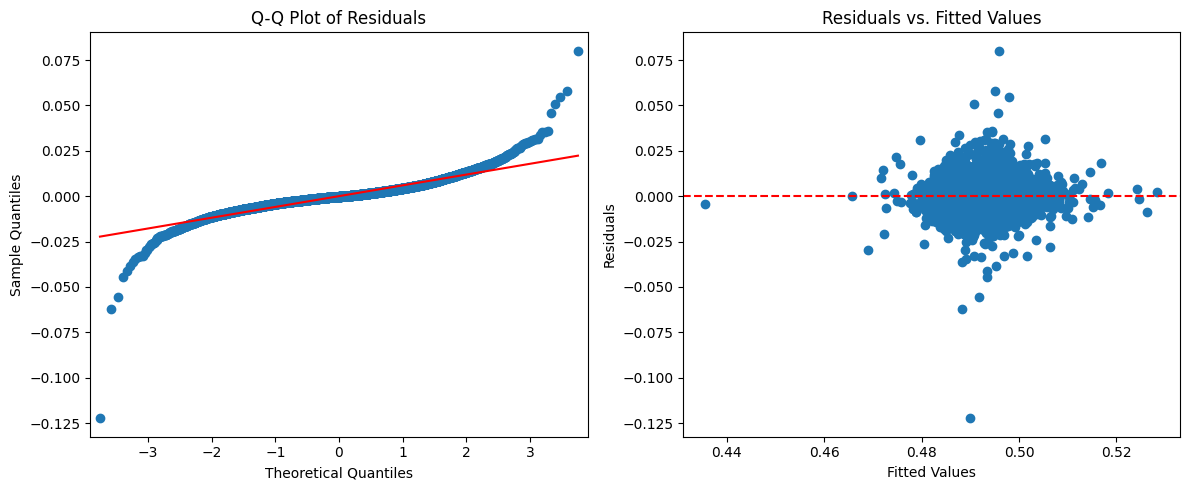


Results Summary:


In [41]:
transformations = {
    'None': lambda x: x,  # No transformation
    'Log': lambda x: np.log(x + 1),  # Logarithmic
    'Log10': lambda x: np.log10(x + 1),  # Logarithm base 10
    'Sqrt': lambda x: np.sqrt(x + 1),  # Square root
    'Cubic Root': lambda x: np.cbrt(x),  # Cubic root
    'Exponential': lambda x: np.exp(x) if (x <= np.log(np.finfo(float).max)).all() else np.nan,  # Exponential
    'Box-Cox': lambda x: stats.boxcox(x + 1)[0] if (x >= 0).all() else np.nan,  # Box-Cox
    'Yeo-Johnson': lambda x: stats.yeojohnson(x)[0],  # Yeo-Johnson
    'Reciprocal': lambda x: 1 / (x + 1) if (x != -1).all() else np.nan,  # Reciprocal
    'Square': lambda x: x**2,  # Square
    'Cube': lambda x: x**3,  # Cube
    'Fourth Power': lambda x: x**4,  # Fourth power
    'Inverse Square Root': lambda x: 1 / np.sqrt(x + 1) if (x > 0).all() else np.nan,  # Inverse square root
    'Logit': lambda x: np.log(x / (1 - x)) if (0 < x).all() and (x < 1).all() else np.nan,  # Logit (bounded [0, 1])
    'Arcsine': lambda x: np.arcsin(np.sqrt(x)) if (0 <= x).all() and (x <= 1).all() else np.nan,  # Arcsine
    'Tanh': lambda x: np.tanh(x),  # Hyperbolic tangent
    'Sigmoid': lambda x: 1 / (1 + np.exp(-x)) if (x < np.log(np.finfo(float).max)).all() else np.nan,  # Sigmoid
    'Softplus': lambda x: np.log1p(np.exp(x)),  # Softplus
    'Clipped Log': lambda x: np.log(np.clip(x, 1e-6, None)),  # Clipped log for small values
    'Signed Log': lambda x: np.sign(x) * np.log1p(np.abs(x)),  # Log that preserves the sign
    'Inverse': lambda x: -x,  # Inverse
    'Exponential Decay': lambda x: np.exp(-x) if (x < np.log(np.finfo(float).max)).all() else np.nan,  # Exponential decay
    'Sin': lambda x: np.sin(x),  # Sine
    'Cos': lambda x: np.cos(x),  # Cosine
    'Arctan': lambda x: np.arctan(x),  # Arctangent
    'Sinh': lambda x: np.sinh(x),  # Hyperbolic sine
    'Cosh': lambda x: np.cosh(x),  # Hyperbolic cosine
    'Log-Reciprocal': lambda x: np.log(1 / (x + 1)) if (x > 0).all() else np.nan,  # Log reciprocal
    'Reciprocal of Square': lambda x: 1 / (x**2 + 1) if (x != 0).all() else np.nan  # Reciprocal square
}

def apply_transformation(data, transform, name):
    try:
        transformed = transform(data)
        if pd.isna(transformed).any():
            raise ValueError("NaN values introduced")
        return transformed
    except Exception as e:
        return None
        
ADJ_RSQ_WEIGHT = 1
AIC_WEIGHT = 0.1

def normalize(value, min_value, max_value):
    """Normalize a value to the range [0, 1]."""
    return (value - min_value) / (max_value - min_value) if max_value > min_value else 0

results = []
best_model = None
best_metrics = {'AIC': float('inf'), 'Adj. R-squared': -float('inf')}
best_transformation = None

for name, transform in transformations.items():
    transformed_stock = apply_transformation(apple_sp500['Stock_Excess_Return'], transform, name)
    transformed_market = apply_transformation(apple_sp500['Market_Excess_Return'], transform, name)

    if transformed_stock is None or transformed_market is None:
        continue

    transformed_data = pd.DataFrame({
        'Transformed_Stock_Excess_Return': transformed_stock,
        'Transformed_Market_Excess_Return': transformed_market
    }).dropna()

    try:
        model = smf.ols(
            formula='Transformed_Stock_Excess_Return ~ Transformed_Market_Excess_Return',
            data=transformed_data
        ).fit()
        aic = model.aic
        adj_rsquared = model.rsquared_adj

        normalized_aic = -normalize(aic, min_value=-200000, max_value=0) 
        normalized_adj_rsq = normalize(adj_rsquared, min_value=0, max_value=1)

        combined_metric = (
            AIC_WEIGHT * normalized_aic +
            ADJ_RSQ_WEIGHT * normalized_adj_rsq
        )

        results.append([name, aic, adj_rsquared, combined_metric, model])

        if combined_metric > best_metrics.get('Combined Metric', -float('inf')):
            best_metrics = {'AIC': aic, 'Adj. R-squared': adj_rsquared, 'Combined Metric': combined_metric}
            best_model = model
            best_transformation = name
    except Exception as e:
        print(f"Failed to fit model for transformation {name}: {e}")

results_df = pd.DataFrame(results, columns=["Transformation", "AIC", "Adj. R-squared", "Combined Metric", "Model"]).sort_values("Combined Metric", ascending=False).head(5)

if best_model is not None:
    print("\nBest Model:")
    print(f"Transformation: {best_transformation}")
    print(best_model.summary())

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sm.qqplot(best_model.resid, line='s', ax=ax[0])
    ax[0].set_title('Q-Q Plot of Residuals')
    ax[1].scatter(best_model.fittedvalues, best_model.resid)
    ax[1].axhline(y=0, color='red', linestyle='--')
    ax[1].set_xlabel('Fitted Values')
    ax[1].set_ylabel('Residuals')
    ax[1].set_title('Residuals vs. Fitted Values')
    plt.tight_layout()
    plt.show()

    print("\nResults Summary:")
    results_df[["Transformation", "AIC", "Adj. R-squared", "Combined Metric"]]
else:
    print("No suitable model could be fit with the provided transformations.")



## Summary of Transformed OLS Results

**Best Transformation (Sigmoid):**

Relative to other transformations, Sigmoid achieved the highest combined metric and the lowest AIC while maintaining competitive Adjusted R-squared values.
- This transformation achieved an Adjusted R-squared of 0.385 (38.5%), showing a slight improvement in the explanatory power of the model compared to the baseline
- The AIC improved significantly, with a value of -85,051.82, highlighting better model performance and simplicity
- Other transformations, such as Softplus, Signed Log, and Sqrt, performed closely in terms of Adjusted R-squared but lagged in AIC

Conclusion:
The Sigmoid transformation significantly improved the model's AIC while maintaining a slight improvement in Adjusted R-squared. Despite some residual non-normality at the tails, the model appears to do a moderately good job at capturing the relationship between Apple's excess returns and the market.

Average Rolling Beta (Sigmoid Transformed): 1.2438
Average Adjusted R-squared (Sigmoid Transformed): 0.2904


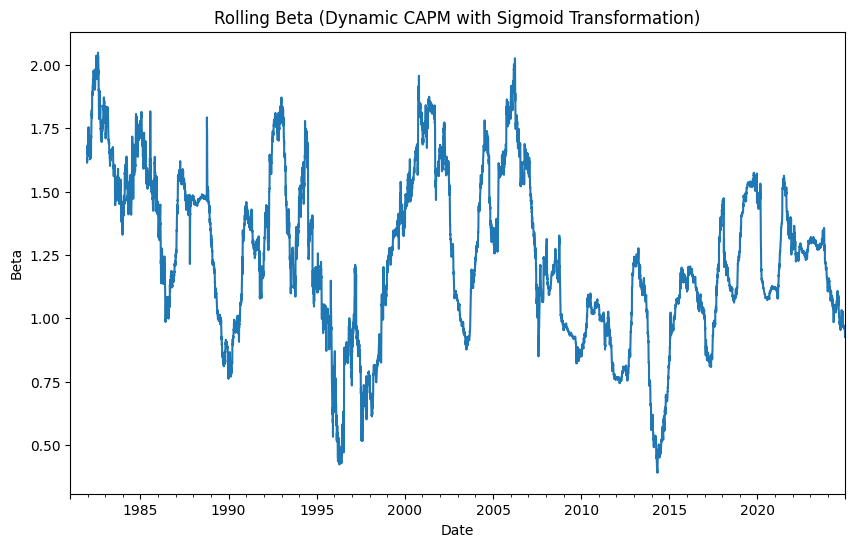

In [42]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

rolling_window = 252

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

apple_sp500['Transformed_Stock_Excess_Return'] = sigmoid(apple_sp500['Stock_Excess_Return'])
apple_sp500['Transformed_Market_Excess_Return'] = sigmoid(apple_sp500['Market_Excess_Return'])

apple_sp500['const'] = 1 

rolling_betas = []
adjusted_r_squareds = []

for i in range(rolling_window, len(apple_sp500)):
    window_data = apple_sp500.iloc[i-rolling_window:i]
    
    CAPM_model = smf.ols(
        formula='Transformed_Stock_Excess_Return ~ Transformed_Market_Excess_Return', 
        data=window_data
    )
    CAPM_fit = CAPM_model.fit()
    
    rolling_betas.append(CAPM_fit.params['Transformed_Market_Excess_Return'])
    adjusted_r_squareds.append(CAPM_fit.rsquared_adj)

average_beta = np.mean(rolling_betas)
average_adjusted_r2 = np.mean(adjusted_r_squareds)

print(f"Average Rolling Beta (Sigmoid Transformed): {average_beta:.4f}")
print(f"Average Adjusted R-squared (Sigmoid Transformed): {average_adjusted_r2:.4f}")

apple_sp500['Rolling_Beta'] = [None] * rolling_window + rolling_betas

apple_sp500['Rolling_Beta'].plot(title='Rolling Beta (Dynamic CAPM with Sigmoid Transformation)', figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Beta")
plt.show()

## Intepreting a Rolling Beta

Estimating how Beta dynamically changes over time helps identify shifts in Apple's risk profile relative to the market over different time periods. The relationship between Apple's stock returns and the market's returns is not static and evolves due to various factors, such as market conditions, company performance, sector-specific trends, and broader macroeconomic events.

Key Insights:
- The Average Rolling Beta of 1.2438 indicates that Apple's excess returns are, on average, more sensitive than the market's returns.
- The Average Adjusted R-squared of 0.2904 shows that the market explains about 29% of Apple's transformed excess returns on average.

The Rolling Beta Plot provides a dynamic view of how Apple's beta changes over time:
- Periods of higher beta (e.g., above 1.5) indicate increased sensitivity to market movements, potentially during high volatility or growth phases.
- Periods of lower beta (e.g., below 1.0) suggest reduced sensitivity, possibly due to idiosyncratic factors or defensive market behavior.

Optimal lag length (AIC): 10


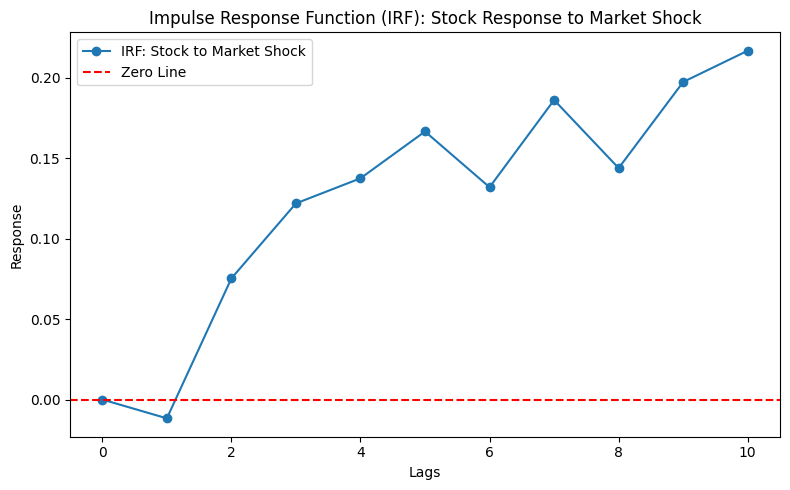


Cumulative Beta (from IRF): 1.3665


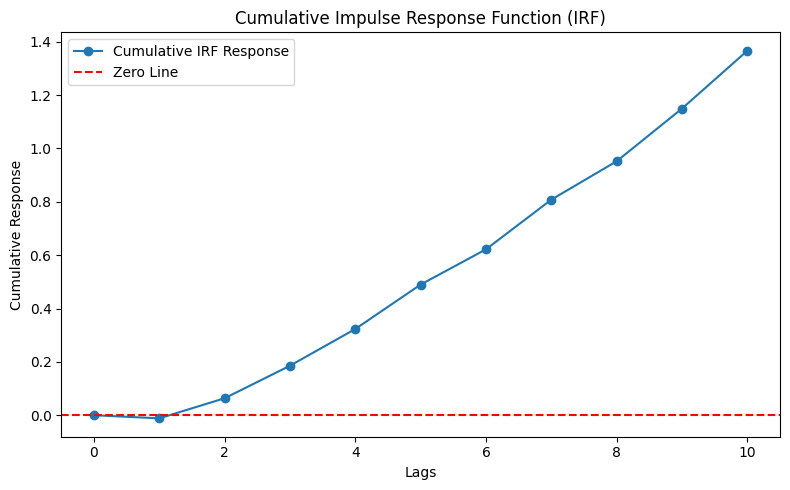

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

returns_data = apple_sp500[['Stock_Excess_Return', 'Market_Excess_Return']].dropna()

max_lags = 10 
var_model = VAR(returns_data)
selected_lag = var_model.select_order(max_lags)
optimal_lags = selected_lag.selected_orders['aic'] 

print(f"Optimal lag length (AIC): {optimal_lags}")
var_fit = var_model.fit(optimal_lags)

beta_coefficients = var_fit.params.filter(like='Market_Excess_Return', axis=0)['Stock_Excess_Return']

cumulative_beta_from_coefficients = beta_coefficients.sum()

forecast_horizon = 10 
irf = var_fit.irf(forecast_horizon)
irf_response = irf.irfs[:, 0, 1] 

plt.figure(figsize=(8, 5))
plt.plot(irf_response, marker='o', label='IRF: Stock to Market Shock')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.title("Impulse Response Function (IRF): Stock Response to Market Shock")
plt.xlabel("Lags")
plt.ylabel("Response")
plt.legend()
plt.tight_layout()
plt.show()

cumulative_beta_from_irf = irf_response.sum()
print(f"\nCumulative Beta (from IRF): {cumulative_beta_from_irf:.4f}")

cumulative_irf_response = irf_response.cumsum()
plt.figure(figsize=(8, 5))
plt.plot(cumulative_irf_response, marker='o', label='Cumulative IRF Response')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.title("Cumulative Impulse Response Function (IRF)")
plt.xlabel("Lags")
plt.ylabel("Cumulative Response")
plt.legend()
plt.tight_layout()
plt.show()

## Why Use VAR Over OLS?

### 1. VAR vs. OLS
- OLS assumes a unidirectional relationship (e.g., `Stock_Excess_Return` depends on `Market_Excess_Return` only).
- VAR treats both variables as endogenous, capturing bidirectional relationships and feedback loops:
  $$Y_t = A_1 Y_{t-1} + A_2 Y_{t-2} + \ldots + \epsilon_t$$
  where $Y_t$ is a vector of endogenous variables (e.g., `Stock_Excess_Return` and `Market_Excess_Return`), $A_i$ are coefficient matrices, and $\epsilon_t$ is the error term.

- **Better for dynamic systems**: VAR accounts for how past values of **both** variables influence the current values, unlike OLS, which focuses on a single direction.

### 2. IRF Provides a Better Beta Estimate
**Beta from IRF** considers the total response (direct + indirect) of `Stock_Excess_Return` to a standardized shock in `Market_Excess_Return`. The IRF translates the estimated parameters $A_i$ into a dynamic response showing how `Stock_Excess_Return` changes to a one-standard-deviation shock in one of the error terms  $\epsilon_t$. Allowing for a more accurate and comprehensive estimation of Beta by accounting for cumulative and time-varying effects:
  $$
  \beta_{\text{IRF}} = \sum_{i=0}^{h} \phi_{i}
  $$
Where:

$\phi_{i}$ represents the impulse response coefficients over $h$ periods.

Unlike coefficient-based Beta, IRF:
  - Accounts for cumulative effects over multiple periods.
  - Includes dynamic feedback between variables.
  - Reflects shocks to the system, offering more practical insights into risk dynamics.

### 3. Mathematical Explanation

### VAR Model
$$
\begin{bmatrix}
Y_{1,t} \\
Y_{2,t}
\end{bmatrix}
=
\begin{bmatrix}
c_1 \\
c_2
\end{bmatrix}
+
\begin{bmatrix}
\phi_{11,1} & \phi_{12,1} \\
\phi_{21,1} & \phi_{22,1}
\end{bmatrix}
\begin{bmatrix}
Y_{1,t-1} \\
Y_{2,t-1}
\end{bmatrix}
+
\ldots +
\begin{bmatrix}
\epsilon_{1,t} \\
\epsilon_{2,t}
\end{bmatrix}
$$

- $Y_{1,t}$: `Stock_Excess_Return`, $Y_{2,t}$: `Market_Excess_Return`.
- $\phi_{ij,k}$: Effect of the $k$-th lag of $Y_j$ on $Y_i$.

### Impulse Response Function (IRF)
- Captures the effect of a one-standard-deviation shock to `Market_Excess_Return` $\epsilon_{2,t}$ on `Stock_Excess_Return` over time:
  $$
  \text{IRF}(h) = \frac{\partial Y_{1,t+h}}{\partial \epsilon_{2,t}}
  $$

- The **cumulative IRF** provides Beta:
  $$
  \beta_{\text{IRF}} = \sum_{h=0}^{H} \text{IRF}(h)
  $$

### Static OLS Beta
OLS Beta assumes constant sensitivity, missing feedback effects and dynamic responses.

$$
\beta_{\text{OLS}} = \frac{\text{Cov}(R_{\text{Stock}}, R_{\text{Market}})}{\text{Var}(R_{\text{Market}})}
$$

## Conclusion
- VAR captures dynamic relationships and is better suited for systems where variables influence each other.
- **IRF-based Beta** is superior because it incorporates cumulative, dynamic effects and provides a more comprehensive risk measure. Which in this case, **is a $\beta$ of 1.3665**


Effective Beta (Random Forest, Scaled): 0.5698
Adjusted Beta: 1.4330


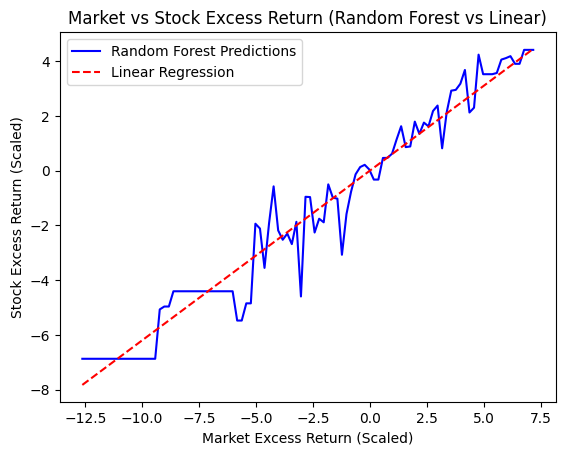

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

X = apple_sp500[['Market_Excess_Return']] 
y = apple_sp500[['Stock_Excess_Return']] 

X, y = X.align(y, join='inner', axis=0)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

importance = rf_model.feature_importances_

X_grid = np.linspace(X_scaled.min(), X_scaled.max(), 100).reshape(-1, 1)
y_grid = rf_model.predict(X_grid)

effective_beta = (y_grid[-1] - y_grid[0]) / (X_grid[-1, 0] - X_grid[0, 0])
print(f"Effective Beta (Random Forest, Scaled): {effective_beta:.4f}")

range_market = apple_sp500[['Market_Excess_Return']].max().values[0] - apple_sp500[['Market_Excess_Return']].min().values[0]
range_stock = apple_sp500[['Stock_Excess_Return']].max().values[0] - apple_sp500[['Stock_Excess_Return']].min().values[0]

beta_adjusted = effective_beta * (range_stock / range_market)
print(f"Adjusted Beta: {beta_adjusted:.4f}")

lin_model = LinearRegression()
lin_model.fit(X_scaled, y_scaled)
y_linear = lin_model.predict(X_grid)

plt.plot(X_grid, y_grid, label="Random Forest Predictions", color="blue")
plt.plot(X_grid, y_linear, label="Linear Regression", color="red", linestyle="--")
plt.xlabel("Market Excess Return (Scaled)")
plt.ylabel("Stock Excess Return (Scaled)")
plt.title("Market vs Stock Excess Return (Random Forest vs Linear)")
plt.legend()
plt.show()

## Non-Linear Relationships and Random Forest Insights

The chart above showcases the relationship between Apple’s excess returns and the market’s excess returns using both a **non-linear Random Forest model** and a traditional linear regression. The non-linear model captures nuanced dynamics that the linear approach misses, revealing Apple's unique performance characteristics across different market conditions.

### General Explanation of the Random Forest Model
- **Random Forest** is a non-linear ensemble learning method that splits the data recursively through decision trees. Each tree is trained on a subset of the data, and the predictions are averaged, providing robust estimates of the relationship between features.
- By capturing non-linear patterns, Random Forest avoids the oversimplification inherent in linear models, making it ideal for complex financial relationships like the one between Apple’s excess returns and market movements.

### Key Insights from Random Forest Beta
1. **Resilience in Down Markets**: When market excess returns are significantly negative, Apple’s excess returns stabilize, decreasing at a slower pace than the market. This behavior suggests a defensive characteristic that shields Apple during downturns.
   
2. **Outperformance in Up Markets**: During strong market rallies, Apple’s excess returns accelerate beyond those of the market. Unlike most assets that exhibit diminishing returns as market performance improves, Apple shows a persistent upward trajectory.

3. **Effective Beta**: The **Random Forest Beta** derived here reflects the dynamic slope of Apple’s excess returns against the market, accounting for non-linear patterns. It provides a richer understanding of Apple’s behavior under varying market conditions compared to traditional linear Beta.

### Conclusion
Random Forest’s ability to capture non-linear relationships unveils Apple’s dual advantage: resilience in down markets and strong outperformance in up markets. These insights position Apple as an attractive asset for investors seeking both stability and upside potential relative to the broader market.


In [46]:
import pandas as pd
import numpy as np

three_years_ago = apple_sp500.index.max() - pd.DateOffset(years=3)
recent_data = apple_sp500.loc[apple_sp500.index >= three_years_ago]

stock_returns_excess = recent_data['Stock_Excess_Return']
benchmark_returns_excess = recent_data['Market_Excess_Return']

annual_factor = np.sqrt(252)
daily_volatility = stock_returns_excess.std()  # Daily volatility
annualized_volatility = daily_volatility * annual_factor

risk_free_rate_dec = (risk_free_rate / 100)
expected_market_return = annualized_return_rate_sp500 
cumulative_beta_from_irf = cumulative_beta_from_irf
rf_beta = beta_adjusted 

expected_stock_return_irf = risk_free_rate_dec + cumulative_beta_from_irf * (expected_market_return - risk_free_rate_dec)
expected_stock_return_rf = risk_free_rate_dec + rf_beta * (expected_market_return - risk_free_rate_dec)

total_return_irf = expected_stock_return_irf + risk_free_rate_dec
total_return_rf = expected_stock_return_rf + risk_free_rate_dec

downside_returns = stock_returns_excess[stock_returns_excess < 0]
downside_volatility = downside_returns.std() * annual_factor

sharpe_ratio_irf = (expected_stock_return_irf) / annualized_volatility
sharpe_ratio_rf = (expected_stock_return_rf) / annualized_volatility

sortino_ratio_irf = (expected_stock_return_irf) / downside_volatility
sortino_ratio_rf = (expected_stock_return_rf) / downside_volatility

treynor_ratio_irf = (expected_stock_return_irf) / cumulative_beta_from_irf
treynor_ratio_rf = (expected_stock_return_rf) / rf_beta

tracking_error = (stock_returns_excess - benchmark_returns_excess).std() * annual_factor
information_ratio = (expected_stock_return_irf - expected_market_return) / tracking_error

threshold_return = risk_free_rate_dec
gain = stock_returns_excess[stock_returns_excess > threshold_return].sum()
loss = abs(stock_returns_excess[stock_returns_excess <= threshold_return].sum())
omega_ratio = gain / loss

max_drawdown = recent_data['Stock_Excess_Return'].min()
calmar_ratio = (expected_stock_return_irf - risk_free_rate_dec) / abs(max_drawdown)

upside_capture = (
    stock_returns_excess[benchmark_returns_excess > 0].mean() /
    benchmark_returns_excess[benchmark_returns_excess > 0].mean()
)
downside_capture = (
    stock_returns_excess[benchmark_returns_excess < 0].mean() /
    benchmark_returns_excess[benchmark_returns_excess < 0].mean()
)
capture_ratio = upside_capture / downside_capture

# Data for table
data = {
    "Metric": [
        "Risk-Free Rate (%)", 
        "Expected Market Return (%)", 
        "Beta (IRF)", 
        "Beta (Random Forest)",
        "Expected Excess Stock Return (IRF) (%)", 
        "Expected Excess Stock Return (RF) (%)",
        "Sharpe Ratio (IRF)", 
        "Sharpe Ratio (RF)",
        "Sortino Ratio (IRF)", 
        "Sortino Ratio (RF)",
        "Treynor Ratio (IRF)", 
        "Treynor Ratio (RF)",
        "Information Ratio", 
        "Omega Ratio", 
        "Calmar Ratio",
        "Upside Capture Ratio", 
        "Downside Capture Ratio",
        "Capture Ratio (UC / DC)"
    ],
    "Value": [
        round(risk_free_rate, 2), 
        round(expected_market_return * 100, 2), 
        round(cumulative_beta_from_irf, 4), 
        round(rf_beta, 4),
        round(expected_stock_return_irf * 100, 2), 
        round(expected_stock_return_rf * 100, 2),
        round(sharpe_ratio_irf, 4),
        round(sharpe_ratio_rf, 4),
        round(sortino_ratio_irf, 4),
        round(sortino_ratio_rf, 4),
        round(treynor_ratio_irf, 4),
        round(treynor_ratio_rf, 4),
        round(information_ratio, 4),
        round(omega_ratio, 4),
        round(calmar_ratio, 4),
        round(upside_capture, 4),
        round(downside_capture, 4),
        round(capture_ratio, 4)
    ],
    "Definition": [
        "The return of a risk-free asset (e.g., government bonds).", 
        "Average annualized return of the market benchmark (S&P 500).", 
        "Beta estimated via Impulse Response Function (IRF).", 
        "Beta estimated using Random Forest regression.",
        "Expected stock return above the risk-free rate (IRF).", 
        "Expected stock return above the risk-free rate (RF).",
        "Risk-adjusted return using annualized volatility (IRF).", 
        "Risk-adjusted return using annualized volatility (RF).",
        "Risk-adjusted return using downside deviation (IRF).", 
        "Risk-adjusted return using downside deviation (RF).",
        "Risk-adjusted return per unit of beta risk (IRF).", 
        "Risk-adjusted return per unit of beta risk (RF).",
        "Return relative to the benchmark's tracking error.", 
        "Gain-to-loss ratio above the threshold (risk-free rate).", 
        "Return relative to the maximum drawdown.",
        "Portfolio return relative to benchmark gains.", 
        "Portfolio return relative to benchmark losses.", 
        "Upside capture divided by downside capture."
    ]
}

# Create and print DataFrame
df = pd.DataFrame(data)

print("CAPM Estimates and Risk Metrics (Last 3 Years):\n")
print(df.to_string(index=False))


CAPM Estimates and Risk Metrics (Last 3 Years):

                                Metric   Value                                                   Definition
                    Risk-Free Rate (%)  4.2400    The return of a risk-free asset (e.g., government bonds).
            Expected Market Return (%) 10.3400 Average annualized return of the market benchmark (S&P 500).
                            Beta (IRF)  1.3665          Beta estimated via Impulse Response Function (IRF).
                  Beta (Random Forest)  1.4330               Beta estimated using Random Forest regression.
Expected Excess Stock Return (IRF) (%) 12.5700        Expected stock return above the risk-free rate (IRF).
 Expected Excess Stock Return (RF) (%) 12.9800         Expected stock return above the risk-free rate (RF).
                    Sharpe Ratio (IRF)  0.4658      Risk-adjusted return using annualized volatility (IRF).
                     Sharpe Ratio (RF)  0.4808       Risk-adjusted return using annuali

C:\Users\alexa\AppData\Local\Temp\ipykernel_22816\3088771309.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


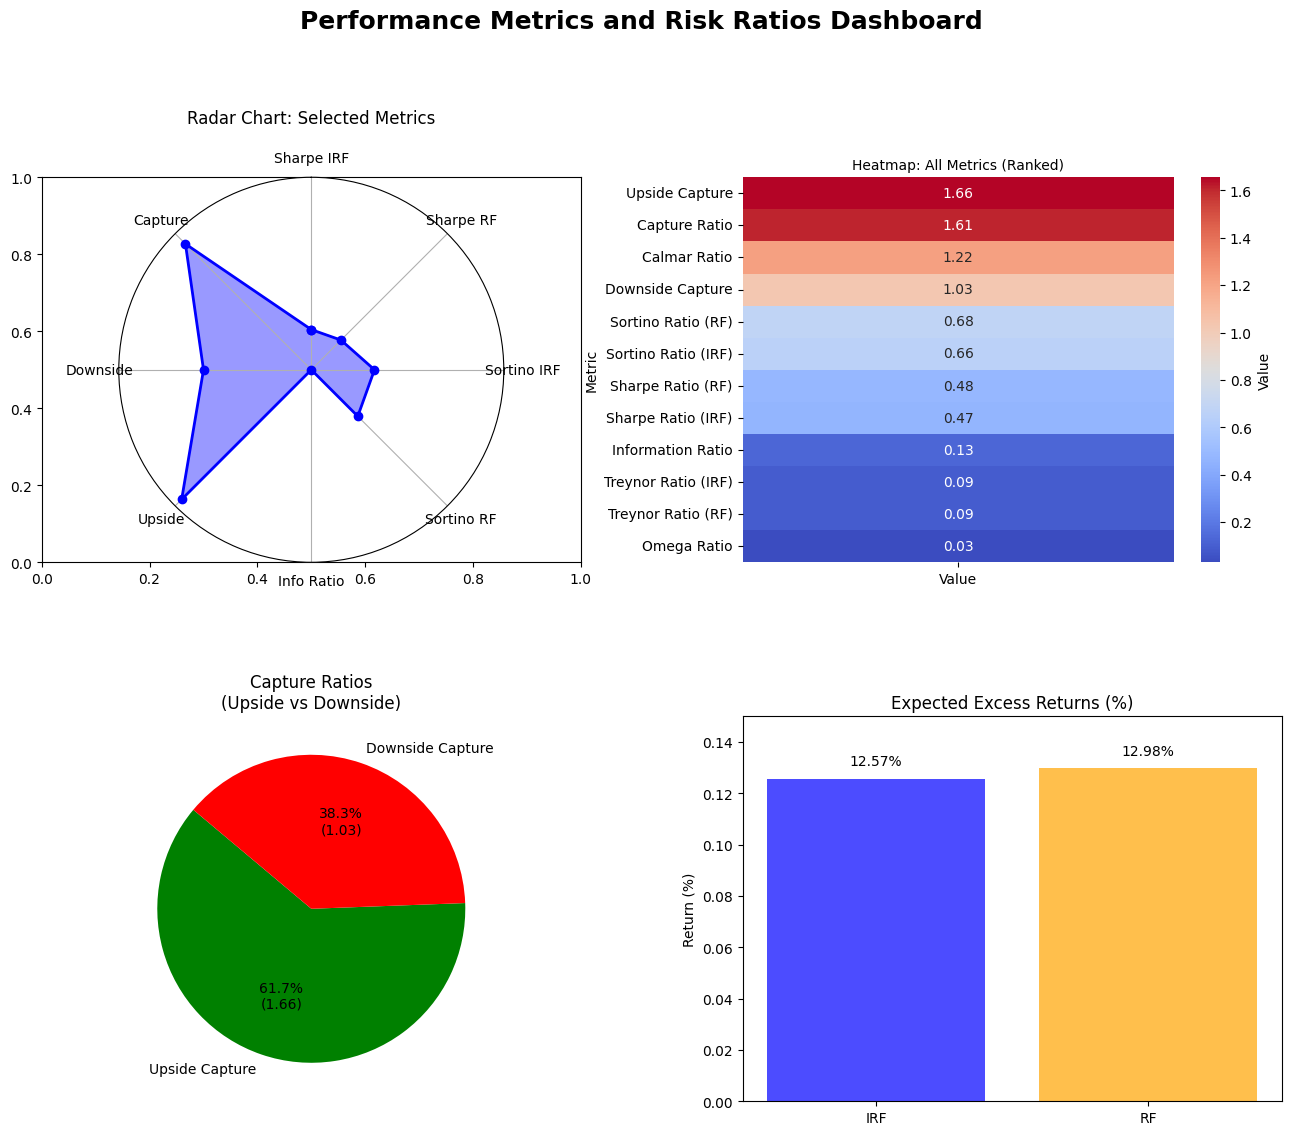

Text(0.5, 1.0, 'Radar Chart: Selected Metrics')

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns

data = {
    "Metric": [
        "Sharpe Ratio (IRF)", "Sharpe Ratio (RF)", "Sortino Ratio (IRF)", 
        "Sortino Ratio (RF)", "Treynor Ratio (IRF)", "Treynor Ratio (RF)", 
        "Information Ratio", "Omega Ratio", "Calmar Ratio", "Upside Capture", 
        "Downside Capture", "Capture Ratio"
    ],
    "Value": [
        sharpe_ratio_irf, sharpe_ratio_rf, sortino_ratio_irf, sortino_ratio_rf, 
        treynor_ratio_irf, treynor_ratio_rf, information_ratio, omega_ratio, 
        calmar_ratio, upside_capture, downside_capture, capture_ratio
    ]
}
df = pd.DataFrame(data)

radar_df = df[~df["Metric"].isin(["Treynor Ratio (IRF)", "Treynor Ratio (RF)", "Omega Ratio", "Calmar Ratio"])]

metrics = radar_df["Metric"].values
abbreviated_metrics = [
    "Sharpe IRF", "Sharpe RF", "Sortino IRF", "Sortino RF", 
    "Info Ratio", "Upside", "Downside", "Capture"
]
values = (radar_df["Value"] - radar_df["Value"].min()) / (radar_df["Value"].max() - radar_df["Value"].min())
values = np.append(values, values[0])  # Close the radar chart

heatmap_data = df.sort_values(by="Value", ascending=False).set_index("Metric")

sizes = [upside_capture, downside_capture]
labels = ["Upside Capture", "Downside Capture"]
colors = ['green', 'red']

fig, axes = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

radar_ax = plt.subplot(2, 2, 1, polar=True) 
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]
radar_ax.set_theta_offset(pi / 2)
radar_ax.set_theta_direction(-1)

radar_ax = plt.subplot(2, 2, 1, polar=True) 
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]
radar_ax.set_theta_offset(pi / 2)
radar_ax.set_theta_direction(-1)

radar_ax.plot(angles, values, linewidth=2, linestyle='solid', color='blue', marker='o')
radar_ax.fill(angles, values, color='blue', alpha=0.4)

radar_ax.set_yticks([])  
radar_ax.set_xticks(angles[:-1]) 
radar_ax.set_xticklabels(abbreviated_metrics, fontsize=10) 

radar_ax.set_title("Radar Chart: Selected Metrics", pad=20)

sns.heatmap(
    heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0, 1],
    annot_kws={"size": 10}, cbar_kws={'label': 'Value'}
)
axes[0, 1].set_title("Heatmap: All Metrics (Ranked)", fontsize=10)

axes[1, 0].pie(
    sizes, labels=labels, autopct=lambda p: f'{p:.1f}%\n({p * sum(sizes) / 100:.2f})',
    startangle=140, colors=colors, textprops={'fontsize': 10}
)
axes[1, 0].set_title("Capture Ratios\n(Upside vs Downside)", fontsize=12)

axes[1, 1].bar(["IRF", "RF"], [expected_stock_return_irf, expected_stock_return_rf], color=['blue', 'orange'], alpha=0.7)
axes[1, 1].set_title("Expected Excess Returns (%)", fontsize=12)
axes[1, 1].set_ylabel("Return (%)", fontsize=10)
axes[1, 1].set_ylim(0, 0.15)

for i, v in enumerate([expected_stock_return_irf, expected_stock_return_rf]):
    axes[1, 1].text(i, v + 0.005, f"{v:.2%}", ha='center', fontsize=10, color='black')

fig.suptitle("Performance Metrics and Risk Ratios Dashboard", fontsize=18, fontweight="bold", y=1.02)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
radar_ax.set_yticks([])  # Remove radial ticks
radar_ax.set_xticks(angles[:-1])  # Keep only the category labels
radar_ax.set_xticklabels(abbreviated_metrics, fontsize=10)
radar_ax.set_title("Radar Chart: Selected Metrics", pad=20)

# CAPM and Beta: Applications in Portfolio Management and Stock Valuation

---

## Applications of CAPM and Beta

### 1. Portfolio Management

#### A. Achieving a Target Beta
- **Portfolio Beta Calculation**:
  $$
  \beta_p = \sum_{i=1}^n w_i \cdot \beta_i
  $$
  where:
  $$
  \beta_p \text{ is the portfolio beta, } w_i \text{ is the weight of asset } i, \text{ and } \beta_i \text{ is the beta of asset } i.
  $$

- **Insights from Beta Estimation**:
  - Beta (IRF): $ 1.3665 $
  - Beta (Random Forest): $ 1.4330 $
  $$
  \text{The two beta estimations show slight variability, highlighting potential modeling differences. A beta above } 1 \text{ implies higher sensitivity to market movements. While the IRF beta is slightly lower, the RF beta emphasizes even greater volatility exposure.}
  $$

- **Practical Use**:
  Portfolio managers adjust beta to align portfolios with market conditions:
  - **High Beta**: Amplifies returns in bullish markets but increases risk in downturns.
  - **Low Beta**: Dampens volatility and preserves capital during bearish markets.


- **Dynamic Rebalancing**:
  To achieve a target beta:
  $$
  \text{Increase exposure to high-beta assets during bullish periods to amplify returns.}
  $$
  $$
  \text{Shift to low-beta assets during bearish periods to minimize losses.}
  $$

- **Example**:
  A portfolio targeting $ \beta = 1.2 $ may balance high-beta tech stocks and low-beta consumer staples, achieving both growth and stability.

#### B. Risk Management
- **Managing Market Exposure**:
  By adjusting the portfolio beta, managers fine-tune exposure to systematic risk while reducing unsystematic risk through diversification.

- **Hedging**:
  $$
  \text{Assets with low or negative beta (e.g., bonds or inverse ETFs) are critical for offsetting market risk.}
  $$

#### Insights from Calculated Metrics:
- **Capture Ratios**:
  - Upside Capture Ratio: $ 1.6558 $
  - Downside Capture Ratio: $ 1.0277 $
  $$
  \text{These values show strong participation in market gains relative to losses, with the portfolio capturing } 61.7\% \text{ more upside than downside. This is a hallmark of effective risk management.}
  $$

- **Risk-Adjusted Metrics**:
  - Sharpe Ratio (RF): $ 0.4808 $
  - Sortino Ratio (RF): $ 0.6783 $
  $$
  \text{While the Sortino Ratio focuses on downside deviations, its value below } 1 \text{ indicates that returns are not exceptionally high relative to downside risk. For many investors, a Sortino Ratio above } 1 \text{ is preferred for robust risk-adjusted performance.}
  $$

---

### 2. Comparative Valuation Across Stocks

#### A. Risk-Adjusted Expected Returns
- CAPM helps compare **expected returns** for stocks with similar beta values:
  $$
  E(R_i) = R_f + \beta_i \cdot (E(R_m) - R_f)
  $$
  - Stocks with similar beta values should have comparable expected returns.
  - Deviations from expected returns may indicate **overvaluation** or **undervaluation**.

#### B. Alpha Analysis
- CAPM provides a benchmark for evaluating actual returns:
  $$
  \alpha = R_i - \left( R_f + \beta_i \cdot (E(R_m) - R_f) \right)
  $$
  - Positive alpha: The stock outperforms CAPM expectations, signaling potential undervaluation.
  - Negative alpha: The stock underperforms, suggesting overvaluation.

#### Example:
- Stock A and Stock B have:
  - $beta_A = \beta_B = 1.2$
  - Expected return: $ 10\% $.
  - Observed returns:
    - $ R_A = 12\% $, $ \alpha_A = 2\%$ (undervalued).
    - $ R_B = 9\% $, $ \alpha_B = -1\% $ (overvalued).

#### C. Portfolio Screening
- CAPM enables stock ranking based on **alpha** and expected returns, helping investors identify potential securities.

---

### 3. Performance Metrics in Decision-Making

#### Key Metrics
1. **Sharpe Ratio**:
   $$
   \text{Sharpe Ratio} = \frac{E(R_p) - R_f}{\sigma_p}
   $$
   - RF: $ 0.4808 $
   $$
   \text{This indicates moderate returns relative to total risk, but a Sharpe Ratio closer to } 1 \text{ would signify stronger risk-adjusted performance.}
   $$

2. **Sortino Ratio**:
   $$
   \text{Sortino Ratio} = \frac{E(R_p) - R_f}{\sigma_d}
   $$
   - RF: $ 0.6783 $
   $$
   \text{The Sortino Ratio focuses on downside deviations, but a value below } 0.7 \text{ suggests returns are not well-compensated for downside risk. A ratio above } 1 \text{ is typically preferrable.}
   $$

3. **Treynor Ratio**:
   $$
   \text{Treynor Ratio} = \frac{E(R_p) - R_f}{\beta_p}
   $$
   - RF: $ 0.0906 $
   $$
   \text{This reflects low returns per unit of market risk.}
   $$

4. **Capture Ratios**:
   - **Upside Capture Ratio**: $1.6558$
   - **Downside Capture Ratio**: $1.0277$

     $$
     \text{Upside Capture Ratio} = \frac{\text{Portfolio Returns (in Up Markets)}}{\text{Benchmark Returns (in Up Markets)}}
     $$
     $$
     \text{Downside Capture Ratio} = \frac{\text{Portfolio Returns (in Down Markets)}}{\text{Benchmark Returns (in Down Markets)}}
     $$
     $$
     \text{Capture Ratio} = \frac{\text{Upside Capture Ratio}}{\text{Downside Capture Ratio}}
     $$

   $$
   \text{A Capture Ratio of } 1.6111 \text{ highlights the portfolio's effective participation in market gains relative to losses.}
   $$


5. **Calmar Ratio**:
   $$
   \text{Calmar Ratio} = \frac{\text{Annualized Return}}{\text{Maximum Drawdown}}
   $$
   - Value: $1.2223$
   $$
   \text{This is a robust measure of return relative to drawdowns, suitable for assessing portfolios focused on long-term stability. A Calmar Ratio of 1.22 reflects moderate risk-adjusted performance.}
   $$

This discrepancy in the previous metrics underscores the importance of using multiple performance metrics to capture different dimensions of risk and return. While Capture and Calmar ratios reflect Apple’s strength in market conditions and drawdown management, Sortino and Treynor ratios highlight areas for improving risk-adjusted performance, particularly under downside risk and systematic market exposure.

## Conclusion: Insights from CAPM and Beta Analysis for Apple's Performance and Portfolio Strategy

This notebook provides a comprehensive application of the Capital Asset Pricing Model (CAPM) and beta analysis to evaluate Apple's stock performance and guide portfolio management strategies. By leveraging CAPM, we gain valuable insights into systematic risk exposure, stock valuation, and portfolio optimization.

### Key Takeaways:

1. **Portfolio Management**:
   - **Dynamic Beta Adjustments**: The analysis emphasizes the importance of beta in aligning portfolio exposure with market conditions. Apple's beta values suggest its higher sensitivity to market fluctuations, making it suitable for growth-focused strategies during bullish markets but requiring caution in downturns.
   - **Risk Metrics Validation**: Metrics like the Upside Capture Ratio (1.6558) and Calmar Ratio (1.2223) highlight the Apple's strong ability to participate in market gains while managing drawdowns. 
2. **Risk Management**:
   - **Improving Risk-Adjusted Performance**: The Sharpe Ratio (0.4808) and Sortino Ratio (0.6783) indicate moderate risk-adjusted performance but leave room for improvement. Specifically, the Sortino Ratio suggests an opportunity to better compensate for downside risk, underscoring the importance of refining hedging strategies.
   - **Hedging with Low-Beta Assets**: Including low or negative beta assets can further stabilize returns and enhance a portfolio's resilience during market volatility.

3. **Stock Valuation**:
   - **Alpha Insights**: CAPM-based alpha analysis reveals the potential for identifying undervalued or overvalued stocks. Apple's slight positive alpha suggests it delivers excess returns independent of market movements, reflecting strong company fundamentals.
   - **Sector and Peer Comparison**: CAPM enables risk-adjusted comparisons across similar stocks, providing a benchmark for identifying mispriced securities within a portfolio or industry.

4. **Modeling Improvements**:
   - The rolling CAPM beta analysis, combined with sigmoid-transformed returns, offers a dynamic approach to understanding time-varying risk exposures. However, **the relatively low R-squared values in CAPM highlight its limitations**. While CAPM remains a foundational part of portfolio management theory, its reliance on a single market factor to explain stock returns often leads to an incomplete picture. High kurtosis, the Sortino Ratio, and non-normal residuals emphasize the need for expanding beyond CAPM with multi-factor models or incorporating behavioral and macroeconomic elements. This could enhance the accuracy of risk assessment and return predictions.

### Final Assessment:

Apple's stock demonstrates significant strengths, including a high upside capture ratio and a robust ability to leverage market gains. However, risk-adjusted performance metrics like the Sharpe and Sortino ratios indicate room for optimization in compensating for downside risk. 

While CAPM provides a valuable starting point for understanding systematic risk and expected returns, its simplicity comes at the cost of ignoring other significant drivers of performance. By incorporating dynamic rebalancing, expanding factor models, refining hedging strategies, and expanding machine learning methods beyond OLS, investors can achieve a more balanced risk-return profile. CAPM remains an essential yet imperfect tool, best complemented with other approaches to fully capture the complexities of financial markets and portfolio management.

---


# Disclosure:
*This post is for informational and educational purposes only. It does not constitute financial advice. For personalized guidance, please consult a qualified financial professional.*

---

**Author:**  
**Alexander Richt, CFA**

As a dedicated professional in finance and economics, I thrive in roles that integrate technical expertise with strategic decision-making. My passion lies in leveraging cutting-edge programming, advanced modeling, and analytics to deliver impactful results in the corporate, investment, and finance sectors.

**Credentials:**  
- CFA Charterholder  
- MSc in Economics (Econometrics specialization)  
- Multiple technical certifications in analytics, AI, data science and data engineering  